In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from geopy.distance import distance,great_circle
from tqdm import tqdm

# Data

In [3]:
catalog = pd.read_csv('ind_and_bg_probs.csv')

In [6]:
catalog

,target_id,latitude,longitude,time,magnitude,geometry,mc_current,mc_current_above_ref,mu,P_triggered,P_background,zeta_plus_1
0,2,-55.5113,-128.4388,2022-01-15 18:23:04.127,5.7,POINT (-55.5113 -128.4388),5.4,0.0,6.907373e-11,0.998822,1.178415e-03,1.0
1,3,-20.5460,-175.3900,2022-01-15 04:14:45.000,5.8,POINT (-20.546 -175.39),5.4,0.0,6.907373e-11,0.998325,1.674875e-03,1.0
2,4,-7.0422,105.2063,2022-01-14 09:49:20.820,5.4,POINT (-7.0422 105.2063),5.4,0.0,6.907373e-11,0.999999,6.002016e-07,1.0
3,5,-6.8600,105.2887,2022-01-14 09:05:41.461,6.6,POINT (-6.86 105.2887),5.4,0.0,6.907373e-11,0.996362,3.637987e-03,1.0
4,6,-6.6002,147.3665,2022-01-12 13:16:21.730,5.6,POINT (-6.6002 147.3665),5.4,0.0,6.907373e-11,0.998980,1.020001e-03,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
12568,12570,-16.3820,173.2590,2002-04-20 15:59:57.860,6.0,POINT (-16.382 173.259),5.4,0.0,6.907373e-11,0.981736,1.826392e-02,1.0
12569,12571,17.2330,-101.2500,2002-04-18 17:57:27.700,5.9,POINT (17.233 -101.25),5.4,0.0,6.907373e-11,0.999974,2.606205e-05,1.0
12570,12572,-27.5350,-70.5860,2002-04-18 16:08:36.780,6.7,POINT (-27.535 -70.586),5.4,0.0,6.907373e-11,0.978985,2.101521e-02,1.0
12571,12573,-60.6570,-25.8430,2002-04-18 14:17:23.940,5.8,POINT (-60.657 -25.843),5.4,0.0,6.907373e-11,0.999386,6.138115e-04,1.0


In [9]:
time_list = catalog.time.to_numpy()
times=[]
for tt in time_list:
    times.append(datetime.strptime(tt, '%Y-%m-%d %H:%M:%S.%f'))
times=np.array(times)
latitudes = catalog.latitude.to_numpy()
longitudes = catalog.longitude.to_numpy()
magnitudes = catalog.magnitude.to_numpy()

## Nearest-Neighbor Proximity for Earthquakes

In [10]:
n = len(catalog)
eta = np.zeros((n,n)) # proximity matrix between event i and event j
t = np.zeros((n,n)) # time
r = np.zeros((n,n)) # lat

In [11]:
d = 1.3
w = 1

In [14]:
calculate_eta = True
if calculate_eta:
    for i in tqdm(range(n)):
        ti = times[i]
        ri = (latitudes[i],longitudes[i])
        mi = magnitudes[i]
        for j in range(n):
            tj = times[j]
            rj = (latitudes[j],longitudes[j])

            t[i,j] = (tj-ti).total_seconds()
            r[i,j] = great_circle(ri,rj).kilometers

            if t[i,j] > 0:
                eta[i,j] = t[i,j] * ( r[i,j] ** d ) * 10 ** (-w * mi)
            else:
                eta[i,j] = np.inf


100%|██████████| 12573/12573 [29:20<00:00,  6.91it/s]


##### eta_v1 uses w = 0, d = 1.5 as suggested by the Zaliapin & Ben-Zion (2020)


- eta_v1 has not been updated using new version of catalog!

In [13]:
import pickle

# with open('eta_v1.pickle', 'wb') as file:
#     pickle.dump(eta, file, protocol=pickle.HIGHEST_PROTOCOL)

##### eta_v2 uses w = 1, d = 1.3 to recreate the results of Zaliapin and Ben-Zion (2016) 

In [15]:
# import pickle

# with open('eta_v2.pickle', 'wb') as file:
#     pickle.dump(eta, file, protocol=pickle.HIGHEST_PROTOCOL)

##### load eta pickle file

In [16]:
with open('eta_v2.pickle', 'rb') as file:
    eta = pickle.load(file)

In [17]:
df1 = pd.DataFrame(eta)

df1

,0,1,2,3,4,5,6,7,8,9,...,12563,12564,12565,12566,12567,12568,12569,12570,12571,12572
0,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
1,5.862524e+03,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
2,8.869675e+04,3.457414e+04,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
3,5.730251e+03,2.267028e+03,3.703802e-02,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
4,9.689518e+04,3.012005e+04,2.361903e+04,2.317922e+04,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12568,5.683663e+07,6.841654e+06,6.734843e+07,6.730603e+07,2.080353e+07,1.673765e+07,7.219820e+07,7.227955e+07,7.212855e+07,7.213173e+07,...,1.532805e+03,2.874750e+03,2.077008e+04,9.981077e+02,1.910520e+03,inf,inf,inf,inf,inf
12569,1.004028e+08,1.101283e+08,2.464390e+08,2.461243e+08,1.659382e+08,1.362268e+08,7.707981e+07,7.746577e+07,7.703839e+07,7.685846e+07,...,9.081773e+04,7.042089e+04,1.344924e+04,6.085256e+04,6.088584e+04,3.341993e+04,inf,inf,inf,inf
12570,9.089490e+06,2.054161e+07,3.671971e+07,3.678213e+07,3.176725e+07,1.964633e+07,2.736795e+07,2.744406e+07,2.735855e+07,2.732379e+07,...,1.788297e+04,1.423795e+04,1.591892e+03,1.090883e+04,1.244710e+04,6.594109e+03,105.731527,inf,inf,inf
12571,7.080470e+07,1.683999e+08,1.849609e+08,1.854296e+08,2.093873e+08,1.314001e+08,3.252884e+08,3.259932e+08,3.251508e+08,3.248626e+08,...,1.354590e+05,1.018615e+05,5.087209e+04,7.710262e+04,7.438650e+04,5.257069e+04,3711.820839,674.191633,inf,inf


In [18]:
nnd = np.zeros(n)
nnd_ind = np.zeros(n)

# i = nnd_ind[j] means that event i is the parent of event j
# the values in nnd_ind tells us the parent of event j
# the values in nnd tell us the distance between event j and its parent
    
for j in np.arange(1,n):
        nnd[j] = np.min(eta[j,0:j])
        nnd_ind[j] = np.argmin(eta[j,0:j])

In [19]:
nnd_ind[100]

99.0

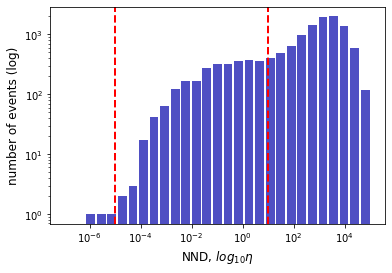

In [20]:
import matplotlib.pyplot as plt

bins = np.logspace(-7,5,30)
plt.xscale('log')
plt.hist(nnd, bins, color='#0504aa', alpha=0.7, rwidth=0.85)
plt.yscale('log')
plt.axvline(x = 10**-5, linewidth = 2, linestyle ="--",
            color ='red')
plt.axvline(x = 10, linewidth = 2, linestyle ="--",
            color ='red')
plt.xlabel('NND, $log_{10}\eta$', fontsize = 12)
plt.ylabel("number of events (log)", fontsize = 12)
plt.show()

# Declustering Algorithm

1. look at scipy tree
2. write a recursive function to find children (depth first tree traversal)
3. embed in a loop over k to get a spanning forest


4. " This bimodality has been documented in multiple regions and on multiple scales (Gentili et al., 2017, 2019; Gu et al., 2013; Kossobokov & Nekrasova, 2017; Moradpour et al., 2014; Peresan & Gentili, 2018; Ruhl et al., 2016; Schoenball et al., 2015; Trugman et al., 2017; Vasylkivska & Huerta, 2017; Zaliapin & Ben-Zion, 2013a, 2013b, 2016a, 2016b). " look at these papers -- anything global?

5. look at zaliapin-zion global paper -- A Global Identification and characterization 
6. try breaking the clusters between by breaking at eta_0 = 10 ** -5

## Recursive function to find children

In [21]:
def children(nnd,nnd_ind, k,eta0,verbose=0):
    if verbose>1: print(f'Looking for children of event {k}:')
        
    # i = nnd_ind[j] means that event i is the parent of event j
    # the values in nnd_ind tells us the parent of event j
    # the values in nnd tell us the distance between event j and its parent
    
    # Find all children
    c = np.where(k == nnd_ind)[0]
    c = c[c!=0] # because event 0 is the parent of event 0
    
    # Limit to children that are close (eta < eta0)
    nearest_neighbor_distances_of_the_children = nnd[c]
    threshold = np.where(nearest_neighbor_distances_of_the_children < eta0)
    if verbose>1: print(f'Found {len(c)} potential children, and '+\
                      f'{len(c[threshold])} are close enough.')
    c = c[threshold]
    c = list(c)
    
    if len(c) == 0:
        if verbose>1: print('\tNo children')
        return []
    else:
        if verbose>0: print(f'\tFound {len(c)} children of {k}: {c}')
        new_c = []
        for i,x in enumerate(c):
            if verbose>1: print(f'\tLooking for grandchildren of {k} that are children of {x} '\
                              f'({i+1} out of {len(c)}):')
            grandchildren = children(nnd, nnd_ind, x,eta0,verbose=verbose)
            for gc in grandchildren:
                new_c.append(gc)

        # Don't modify c until we're outside of the loop
        for nc in new_c:
            c.append(nc)
            
    return c

- The full catalog has no clustering rules

- Using eta0 = 10**5 results in very loose clustering rules (very few related events), while using eta0 = 10 results in moderate clustering rules (moderate number of related earthquakes)

- We conduct ETAS declustering to analyze our results with very strict clustering rules.

In [22]:
from time import perf_counter
t0 = perf_counter()

n_clusters = 0
n_singlets = 0
clusters = []
singlets = [] # catalog of unclustered events
# an event can only be considered a children event if nearest-neigbor distance is < eta0

eta0 = 10
nnd_ind_new = nnd_ind
spanning_forest = []
events_in_spanning_forest = []
verbose = 0

# while True:
    
for i in range(len(nnd)):
# for i in range(1000):
    
   # if len(nnd_ind_new) < 2: 
        # if verbose>0: print('All done')
      #  break
   # i = np.min(nnd_ind_new)
    
#     print(np.array(spanning_forest).flatten())
#     print(i)
#     print(' ')
#     print(f'{i} is in {events_in_spanning_forest}?  {np.isin(i,events_in_spanning_forest)}')
    if np.isin(i,events_in_spanning_forest):
        continue
    
    this_tree = children(nnd, nnd_ind, i,eta0,verbose=verbose)
    this_tree.append(i)
    for j in this_tree:
        events_in_spanning_forest.append(j)
    
    spanning_forest.append(this_tree)
    if len(this_tree)>1:
        if verbose>0: print(f'Cluster {n_clusters} has {len(this_tree)} events.')
        print(this_tree)
        clusters.append(np.array(this_tree))
        n_clusters = n_clusters + 1
    
    else:
        singlets.append(np.array(this_tree))
        n_singlets = n_singlets + 1
    
#     if len(this_tree)=1:
#         singlets.append(np.array(this_tree))
#         n_clusters = n_clusters + 1
    '''
    What is the biggest magnitude event in the list of events, this_tree?
    '''
   # We want to remove this_tree from nnd_ind_new 
   # nnd_ind_new = np.setdiff1d(nnd_ind_new, this_tree, assume_unique=True) # is this the issue? indexing?
    
   # if verbose>1: print(f'There are {len(nnd_ind_new)} events remaining.\n')


print(' ')
print(f'Runtime is {perf_counter()-t0}')
print(f'Number of clusters is {n_clusters}.')

[3, 2]
[7, 8, 9, 6]
[49, 48]
[67, 57]
[60, 61, 62, 58]
[73, 75, 74, 77, 78, 76, 72]
[93, 94, 92]
[97, 95]
[106, 105]
[115, 114]
[119, 118]
[121, 123, 120]
[127, 128, 126]
[169, 186, 162]
[195, 194]
[199, 197]
[210, 206]
[219, 218]
[225, 223]
[246, 245]
[254, 252]
[257, 258, 259, 262, 313, 255]
[264, 261]
[271, 269]
[275, 274]
[283, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 281]
[285, 287, 290, 284]
[289, 288]
[310, 308]
[320, 319]
[324, 323]
[332, 334, 335, 336, 337, 338, 331]
[343, 341]
[345, 346, 348, 344]
[351, 350]
[360, 359]
[376, 375]
[388, 383]
[386, 385]
[403, 402]
[420, 419]
[720, 429]
[433, 434, 432]
[457, 455]
[475, 479, 483, 474]
[481, 482, 480]
[491, 490]
[494, 493]
[508, 509, 507]
[522, 519]
[530, 529]
[548, 547]
[550, 549]
[552, 551]
[562, 561]
[585, 627, 565]
[567, 590, 591, 592, 595, 596, 599, 597, 598, 601, 602, 603, 612, 604, 605, 607, 606, 611, 608, 609, 610, 613, 614, 617, 615, 616, 618, 620, 624, 619, 621, 566]
[574, 575,

[4934, 4933]
[4952, 4950]
[4959, 4957]
[4969, 4967]
[4975, 4974]
[4986, 4980]
[4982, 4981]
[4989, 4988]
[5004, 5000]
[5019, 5005]
[5015, 5014]
[5023, 5024, 5025, 5032, 5026, 5027, 5029, 5031, 5028, 5021]
[5034, 5033]
[5053, 5052]
[5077, 5072]
[5087, 5085]
[5089, 5088]
[5099, 5100, 5098]
[5107, 5103]
[5110, 5109]
[5112, 5111]
[5138, 5139, 5137]
[5149, 5150, 5153, 5142]
[5171, 5170]
[5174, 5173]
[5182, 5180]
[5187, 5183]
[5189, 5195, 5184]
[5191, 5194, 5196, 5197, 5199, 5200, 5201, 5203, 5204, 5205, 5209, 5210, 5211, 5213, 5220, 5212, 5214, 5215, 5216, 5217, 5218, 5219, 5221, 5222, 5223, 5224, 5237, 5225, 5226, 5228, 5246, 5227, 5229, 5230, 5238, 5242, 5231, 5232, 5233, 5234, 5235, 5236, 5245, 5247, 5248, 5190]
[5206, 5208, 5202]
[5243, 5240]
[5252, 5253, 5254, 5255, 5251]
[5284, 5271]
[5274, 5273]
[5309, 5298]
[5300, 5299]
[5316, 5317, 5315]
[5340, 5339]
[5356, 5357, 5355]
[5362, 5361]
[5367, 5366]
[5379, 5380, 5381, 5375]
[5383, 5382]
[5423, 5424, 5422]
[5437, 5435]
[5463, 5456]
[5467,

[9034, 9038, 9048, 9050, 9051, 9053, 9054, 9029]
[9035, 9033]
[9042, 9043, 9045, 9047, 9052, 9039]
[9041, 9040]
[9055, 9049]
[9065, 9064]
[9078, 9080, 9075]
[9079, 9077]
[9101, 9100]
[9104, 9103]
[9112, 9114, 9111]
[9117, 9116]
[9121, 9120]
[9139, 9136]
[9145, 9146, 9147, 9143]
[9149, 9148]
[9154, 9153]
[9161, 9159]
[9170, 9169]
[9184, 9183]
[9193, 9192]
[9218, 9219, 9217]
[9230, 9229]
[9252, 9253, 9254, 9255, 9251]
[9269, 9268]
[9280, 9274]
[9277, 9284, 9275]
[9289, 9295, 9288]
[9291, 9294, 9292, 9293, 9317, 9320, 9321, 9322, 9323, 9327, 9324, 9325, 9326, 9334, 9328, 9330, 9329, 9331, 9332, 9333, 9296, 9297, 9299, 9304, 9301, 9316, 9302, 9305, 9307, 9306, 9309, 9308, 9311, 9312, 9313, 9315, 9314, 9290]
[9349, 9351, 9336]
[9342, 9341]
[9364, 9362]
[9389, 9388]
[9396, 9395]
[9402, 9401]
[9417, 9407]
[9413, 9414, 9412]
[9423, 9424, 9422]
[9429, 9428]
[9443, 9444, 9442]
[9446, 9445]
[9464, 9462]
[9466, 9465]
[9470, 9473, 9469]
[9492, 9471]
[9479, 9478]
[9481, 9482, 9483, 9487, 9485, 9486,

In [23]:
# Finding first event in each cluster

first_event_in_cluster = []
n = len(clusters)

for i in range(n):
    first_event_in_cluster.append(np.min(clusters[i]))

# converting list of arrays to array

first_event_in_cluster = np.concatenate(first_event_in_cluster, axis=None)
singlets = np.concatenate(singlets, axis=None)

In [24]:
moderate_clustered_catalog = set( np.sort (np.concatenate ((first_event_in_cluster,singlets)) ) )

In [25]:
print(f'The full catalog contains {len(catalog)} events.')

print(f'The catalog declustered using Zaliapin & Ben-Zions Nearest Neighbor method contains {len(moderate_clustered_catalog)} events.')

print(f'The catalog declustered using Mizrahis ETAS model contains 537 events.')

The full catalog contains 12573 events.
The catalog declustered using Zaliapin & Ben-Zions Nearest Neighbor method contains 9865 events.
The catalog declustered using Mizrahis ETAS model contains 537 events.


In [26]:
# Saving list of events in moderately clustered catalog to csv

pd.DataFrame(moderate_clustered_catalog).to_csv("NND_declustered_catalog.csv")